# 1. Preparación de Dataset

## Importaciones

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
import os
import re


######## Machine Learning

from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier, GradientBoostingRegressor, VotingClassifier, GradientBoostingClassifier
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, mean_squared_error, accuracy_score, classification_report
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, cross_val_score, cross_val_predict
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler, MaxAbsScaler, MinMaxScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

from xgboost import XGBClassifier


# 1. Preprocesamiento

## 1.1 Preparación de datos

### 1.1.1 Adquisición (Extracción)

Obtenemos los datos para generar el Modelo de ML.

In [2]:
BASE_PATH = 'Datawarehouse'
SITIOS_FILE_URL = 'restaurantes.parquet'

df_restaurantes = pd.read_parquet(os.path.join(BASE_PATH, SITIOS_FILE_URL))

### 1.1.2 Transformación

In [3]:
## Origen: 1 si es Maps, 0 si es Yelp
df_restaurantes.loc[:, 'origen'] =  df_restaurantes.loc[:, 'id_restaurante'].apply(lambda x: 1 if len(x) > 22 else 0)
df_restaurantes['id_estado'] = df_restaurantes['id_estado'].apply(lambda x: int(x))

df_restaurantes.sample(1)

,id_restaurante,id_estado,nombre,categorias,cantidad_resenas,latitud,longitud,atributos,calificacion,origen
30433,0x89c8031e487ff6c7:0xb45b11ee4fe93e27,20,Cowboy Row Saloon & Chophouse,['Restaurant'],44,39.280461,-76.575138,"{'AcceptsInsurance': None, 'Accessibility': ['...",4.300781,1


In [4]:
df_restaurantes.info()

<class 'pandas.core.frame.DataFrame'>
Index: 111914 entries, 3 to 212012
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   id_restaurante    111914 non-null  object 
 1   id_estado         111914 non-null  int64  
 2   nombre            111914 non-null  object 
 3   categorias        111914 non-null  object 
 4   cantidad_resenas  111914 non-null  int64  
 5   latitud           111914 non-null  float64
 6   longitud          111914 non-null  float64
 7   atributos         111046 non-null  object 
 8   calificacion      111914 non-null  float64
 9   origen            111914 non-null  int64  
dtypes: float64(3), int64(3), object(4)
memory usage: 9.4+ MB


En la columna atributos tenemos la información condensada de las características relevantes de los restaurantes. Debemos realizar la normalización.

In [5]:
df_atributos = pd.json_normalize(df_restaurantes.atributos)

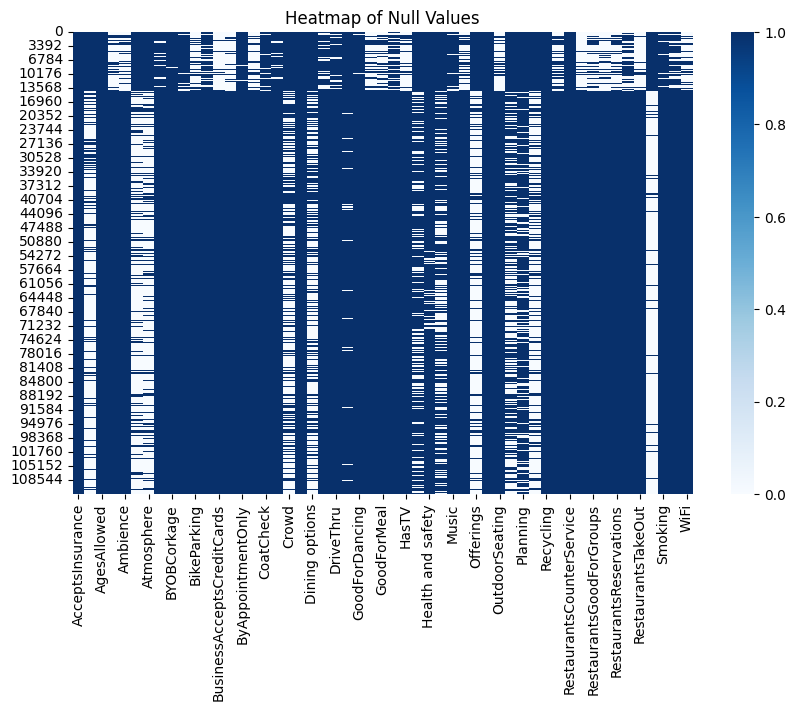

In [6]:
nulos = df_atributos.isna().sum()
nulos_df = pd.DataFrame(nulos, columns=['nulos'])

plt.figure(figsize=(10, 6))
sns.heatmap(df_atributos.isnull(), cmap='Blues', cbar=True)
plt.title('Heatmap of Null Values')
plt.show()

Vemos que el color azul es para valores nulos, por lo tanto elegimos las que menos valores nulos tienen.

In [7]:
columnas = ['Accessibility',
 'Amenities',
 'Atmosphere',
 'Crowd',
 'Dining options',
 'Health & safety',
 'Highlights',
 'Offerings',
 'Payments',
 'Popular for',
 'Service options']

## 1.2 Atributos

Comenzamos a descomponer la columna atributos

In [8]:
atributos = columnas
df_atributos = pd.json_normalize(df_restaurantes.atributos).reset_index()[atributos].fillna(np.ndarray([]))

In [9]:
for col in atributos:
    df_atributos[col] = df_atributos[col].apply(str)
    df_atributos[col] = df_atributos[col].apply(lambda c: "[]" if c == '0.0' else c)
    

In [10]:
df_atributos.sample(3)

,Accessibility,Amenities,Atmosphere,Crowd,Dining options,Health & safety,Highlights,Offerings,Payments,Popular for,Service options
50166,['Wheelchair accessible elevator' 'Wheelchair ...,['Bar onsite' 'High chairs' 'Wi-Fi'],['Casual' 'Cozy'],['Family-friendly' 'Groups' 'Tourists'],['Lunch' 'Dessert' 'Seating'],[],['Great beer selection' 'Great cocktails' 'Gre...,['Alcohol' 'Beer' 'Cocktails' 'Coffee' 'Comfor...,['Debit cards' 'Credit cards'],['Lunch' 'Dinner' 'Solo dining'],['Delivery' 'Takeout' 'Dine-in']
11284,[],[],[],[],[],[],[],[],[],[],[]
65731,['Wheelchair accessible entrance'],['Good for kids'],['Casual'],['Tourists'],[],[],[],['Comfort food' 'Quick bite'],[],['Lunch' 'Solo dining'],['Delivery' 'Takeout']


### 1.2.1 Accessibility

In [11]:
df_atributos['Accessibility'] = df_atributos['Accessibility'].apply(lambda s: re.sub(r"'", "\"", s)).apply(lambda s: re.sub(r'"\s*"','","', s)).apply(json.loads)

df_atributos['Accessibility'].sample(1)

83380    [Wheelchair accessible entrance]
Name: Accessibility, dtype: object

In [12]:
columnas_accesibilidad =  df_atributos['Accessibility'].explode().unique()[1:].tolist()


In [13]:
df_accesibilidad = pd.DataFrame([[False] * len(columnas_accesibilidad)] * df_atributos.shape[0], columns=columnas_accesibilidad)

In [14]:
df_accesibilidad.sample(3)

,Wheelchair accessible entrance,Wheelchair accessible parking lot,Wheelchair accessible seating,Wheelchair accessible restroom,Wheelchair accessible elevator,Wheelchair-accessible car park,Wheelchair-accessible entrance,Wheelchair-accessible seating,Wheelchair-accessible toilet,Wheelchair-accessible lift,Assisted listening devices
111278,False,False,False,False,False,False,False,False,False,False,False
34183,False,False,False,False,False,False,False,False,False,False,False
3586,False,False,False,False,False,False,False,False,False,False,False


In [15]:
for i, row in enumerate(df_atributos['Accessibility']):
    for j, val in enumerate(row):
        df_accesibilidad.loc[i, val] = True


In [16]:
df_restaurantes = df_restaurantes.reset_index().reset_index().drop(columns=['index']).rename({'level_0': 'index'}, axis=1, errors='ignore')
df_accesibilidad.reset_index().merge(df_restaurantes, on="index").sample(3)


,index,Wheelchair accessible entrance,Wheelchair accessible parking lot,Wheelchair accessible seating,Wheelchair accessible restroom,Wheelchair accessible elevator,Wheelchair-accessible car park,Wheelchair-accessible entrance,Wheelchair-accessible seating,Wheelchair-accessible toilet,...,id_restaurante,id_estado,nombre,categorias,cantidad_resenas,latitud,longitud,atributos,calificacion,origen
44644,44644,True,False,False,False,False,False,False,False,False,...,0x89008304914a2945:0x13eb2602be04e427,33,Piper's Bar & Grill,"['Bar', 'Restaurant']",17,33.921539,-78.512017,"{'AcceptsInsurance': None, 'Accessibility': ['...",4.601562,1
105724,105724,True,False,False,False,False,False,False,False,False,...,0x89c96d97d84f634f:0x9249e0bfd9860251,38,Auntie Anne's,"['Pretzel store', 'Bakery', 'Cafe', 'Restaurant']",2,40.165981,-77.597133,"{'AcceptsInsurance': None, 'Accessibility': ['...",1.000000,1
49046,49046,True,False,True,True,False,False,False,False,False,...,0x888603212bf6461b:0x4f0af1991728748b,1,Twelve25 Sports Bar & Entertainment Venue,"['Sports bar', 'Disco club', 'Event planner', ...",11,33.210805,-87.554227,"{'AcceptsInsurance': None, 'Accessibility': ['...",4.300781,1


In [17]:
df_accesibilidad.columns = ["access_" + c for c in df_accesibilidad.columns]
union = df_accesibilidad.reset_index().merge(df_restaurantes, on="index")

In [18]:
union.sample(3)

,index,access_Wheelchair accessible entrance,access_Wheelchair accessible parking lot,access_Wheelchair accessible seating,access_Wheelchair accessible restroom,access_Wheelchair accessible elevator,access_Wheelchair-accessible car park,access_Wheelchair-accessible entrance,access_Wheelchair-accessible seating,access_Wheelchair-accessible toilet,...,id_restaurante,id_estado,nombre,categorias,cantidad_resenas,latitud,longitud,atributos,calificacion,origen
74991,74991,True,False,False,False,False,False,False,False,False,...,0x88f5012c7553f3ed:0xe319b38b4bbd965d,10,The House,['Restaurant'],45,33.740880,-84.289288,"{'AcceptsInsurance': None, 'Accessibility': ['...",4.101562,1
46019,46019,True,False,False,False,False,False,False,False,False,...,0x88f5a5ab8f5cb53f:0x3400834237df276a,10,La Sabrosita Restaurant & Catering,"['Venezuelan restaurant', 'Restaurant']",38,33.917415,-84.115970,"{'AcceptsInsurance': None, 'Accessibility': ['...",4.601562,1
48386,48386,True,True,True,False,False,False,False,False,False,...,0x89bac19fc5749f3b:0x72f955a21d4df41a,46,El Tapatio Mexican Restaurant,['Restaurant'],18,36.768713,-76.015595,"{'AcceptsInsurance': None, 'Accessibility': ['...",4.199219,1


In [19]:
df_atributos['Accessibility'].iloc[8536]

[]

### 1.2.2 Amenities

In [20]:
df_atributos['Amenities'] = df_atributos['Amenities'].apply(lambda s: re.sub(r"'", "\"", s)).apply(lambda s: re.sub(r'"\s*"','","', s)).apply(json.loads)

columnas_amenities = df_atributos['Amenities'].explode().unique()[1:].tolist()
df_amenities = pd.DataFrame([[False] * len(columnas_amenities)] * df_atributos.shape[0], columns=columnas_amenities)

for i, row in enumerate(df_atributos['Amenities']):
    for j, val in enumerate(row):
        df_amenities.loc[i, val] = True

df_amenities.columns = ["amen_" + c for c in df_amenities.columns]
union = df_amenities.reset_index().merge(union, on="index")

### 1.2.3 Atmosphere

In [21]:
df_atributos['Atmosphere'] = df_atributos['Atmosphere'].apply(lambda s: re.sub(r"'", "\"", s)).apply(lambda s: re.sub(r'"\s*"','","', s)).apply(json.loads)

columnas_atmosphere = df_atributos['Atmosphere'].explode().unique()[1:].tolist()

df_atmosphere = pd.DataFrame([[False] * len(columnas_atmosphere)] * df_atributos.shape[0], columns=columnas_atmosphere)

for i, row in enumerate(df_atributos['Atmosphere']):
    for j, val in enumerate(row):
        df_atmosphere.loc[i, val] = True

df_atmosphere.columns = ["atmos_" + c for c in df_atmosphere.columns]
union = df_atmosphere.reset_index().merge(union, on="index")

### 1.2.4 Crowd

In [22]:
df_atributos['Crowd'] = df_atributos['Crowd'].apply(lambda s: re.sub(r"'", "\"", s)).apply(lambda s: re.sub(r'"\s*"','","', s)).apply(json.loads)

columnas_crowd = df_atributos['Crowd'].explode().unique()[1:].tolist()

df_crowd = pd.DataFrame([[False] * len(columnas_crowd)] * df_atributos.shape[0], columns=columnas_crowd)

for i, row in enumerate(df_atributos['Crowd']):
    for j, val in enumerate(row):
        df_crowd.loc[i, val] = True

df_crowd.columns = ["crowd_" + c for c in df_crowd.columns]
union = df_crowd.reset_index().merge(union, on="index")       

### 1.2.5 Dinning Options

In [23]:
df_atributos['Dining options'] = df_atributos['Dining options'].apply(lambda s: re.sub(r"'", "\"", s)).apply(lambda s: re.sub(r'"\s*"','","', s)).apply(json.loads)

columnas_dining = df_atributos['Dining options'].explode().unique()[1:].tolist()
df_dining = pd.DataFrame([[False] * len(columnas_dining)] * df_atributos.shape[0], columns=columnas_dining)

for i, row in enumerate(df_atributos['Dining options']):
    for j, val in enumerate(row):
        df_dining.loc[i, val] = True

df_dining.columns = ["dining_" + c for c in df_dining.columns]
union = df_dining.reset_index().merge(union, on="index")

### 1.2.6 Health & safety

In [24]:
df_atributos['Health & safety'] = df_atributos['Health & safety'].apply(lambda s: re.sub(r"'", "\"", s)).apply(lambda s: re.sub(r'"\s*"','","', s)).apply(json.loads)

columnas_health = df_atributos['Health & safety'].explode().unique()[1:].tolist()

df_health = pd.DataFrame([[False] * len(columnas_health)] * df_atributos.shape[0], columns=columnas_health)

for i, row in enumerate(df_atributos['Health & safety']):
    for j, val in enumerate(row):
        df_health.loc[i, val] = True

df_health.columns = ["health_" + c for c in df_health.columns]
union = df_health.reset_index().merge(union, on="index")        


### 1.2.7 Highlights

In [25]:
df_atributos['Highlights'] = df_atributos['Highlights'].apply(lambda s: re.sub(r"'", "\"", s)).apply(lambda s: re.sub(r'"\s*"','","', s)).apply(json.loads)

columnas_high = df_atributos['Highlights'].explode().unique()[1:].tolist()

df_high = pd.DataFrame([[False] * len(columnas_high)] * df_atributos.shape[0], columns=columnas_high)

for i, row in enumerate(df_atributos['Highlights']):
    for j, val in enumerate(row):
        df_high.loc[i, val] = True

df_high.columns = ["high_" + c for c in df_high.columns]
union = df_high.reset_index().merge(union, on="index")

### 1.2.8 Offerings

In [26]:
df_atributos['Offerings'] = df_atributos['Offerings'].apply(lambda r: r.replace("Kids'", "Kids"))

df_atributos['Offerings'] = df_atributos['Offerings'].apply(lambda s: re.sub(r"'", "\"", s)).apply(lambda s: re.sub(r'"\s*"','","', s)).apply(json.loads)

columnas_offerings = df_atributos['Offerings'].explode().unique()[1:].tolist()

df_offering = pd.DataFrame([[False] * len(columnas_offerings)] * df_atributos.shape[0], columns=columnas_offerings)

for i, row in enumerate(df_atributos['Offerings']):
    for j, val in enumerate(row):
        df_offering.loc[i, val] = True

df_offering.columns = ["offer_" + c for c in df_offering.columns]
union = df_offering.reset_index().merge(union, on="index")

### 1.2.9 Payments

In [27]:
df_atributos['Payments'] = df_atributos['Payments'].apply(lambda s: re.sub(r"'", "\"", s)).apply(lambda s: re.sub(r'"\s*"','","', s)).apply(json.loads)

columnas_payments = df_atributos['Payments'].explode().unique()[1:].tolist()

df_payments = pd.DataFrame([[False] * len(columnas_payments)] * df_atributos.shape[0], columns=columnas_payments)

for i, row in enumerate(df_atributos['Payments']):
    for j, val in enumerate(row):
        df_payments.loc[i, val] = True

df_payments.columns = ["pay_" + c for c in df_payments.columns]
union = df_payments.reset_index().merge(union, on="index")

### 1.2.10 Popular for

In [28]:
df_atributos['Popular for'] = df_atributos['Popular for'].apply(lambda s: re.sub(r"'", "\"", s)).apply(lambda s: re.sub(r'"\s*"','","', s)).apply(json.loads)

columnas_popular = df_atributos['Popular for'].explode().unique()[1:].tolist()

df_popular = pd.DataFrame([[False] * len(columnas_popular)] * df_atributos.shape[0], columns=columnas_popular)

for i, row in enumerate(df_atributos['Popular for']):
    for j, val in enumerate(row):
        df_popular.loc[i, val] = True

df_popular.columns = ["popular_" + c for c in df_popular.columns]
union = df_popular.reset_index().merge(union, on="index")



### 1.2.11 Service Options

In [29]:
df_atributos['Service options'] = df_atributos['Service options'].apply(lambda s: re.sub(r"'", "\"", s)).apply(lambda s: re.sub(r'"\s*"','","', s)).apply(json.loads)

columnas_service = df_atributos['Service options'].explode().unique()[1:].tolist()

df_service = pd.DataFrame([[False] * len(columnas_service)] * df_atributos.shape[0], columns=columnas_service)

for i, row in enumerate(df_atributos['Service options']):
    for j, val in enumerate(row):
        df_service.loc[i, val] = True

df_service.columns = ["service_" + c for c in df_service.columns]

union = df_service.reset_index().merge(union, on="index")

Luego de haber trabajado todas las columnas que utilizaremos, podemos salvar el dataframe resultante.

In [30]:
union.to_parquet("df_normalizado.parquet")

# 2. Machine Learning

## 2.1 Tareas Previas

### 2.1.1 Adquisición de Archivos

In [261]:
df_normalizado = pd.read_parquet("df_normalizado.parquet")

In [ ]:
df_normalizado.info()

### 2.1.2 Recorte de Features

Subset de columnas features, que son la columna atributos desplegada

In [262]:
subset = [col for col in df_normalizado.columns if '_' in col and col not in ['id_restaurante', 'id_estado', 'cantidad_resenas'] ]


Unificación de Features

In [263]:
df = pd.DataFrame(data=None)

# Accesibilidad
df['index'] = df_normalizado.index
df['access_Wheelchair accessible entrance'] = df_normalizado['access_Wheelchair accessible entrance'] | df_normalizado['access_Wheelchair-accessible entrance']
df['access_Wheelchair accessible parking lot'] = df_normalizado['access_Wheelchair accessible parking lot'] | df_normalizado['access_Wheelchair-accessible car park']
df['access_Wheelchair accessible restroom'] = df_normalizado['access_Wheelchair accessible restroom'] | df_normalizado['access_Wheelchair-accessible toilet']
df['access_Wheelchair accessible seating'] = df_normalizado['access_Wheelchair accessible seating'] | df_normalizado['access_Wheelchair-accessible seating']
df['access_Wheelchair accessible elevator'] = df_normalizado['access_Wheelchair accessible elevator'] | df_normalizado['access_Wheelchair-accessible lift']

# Amenities
df['amen_Bar onsite'] = df_normalizado['amen_Bar onsite'] | df_normalizado['amen_Bar on site']
df['amen_Gender-neutral restroom'] = df_normalizado['amen_Gender-neutral restroom'] | df_normalizado['amen_Gender-neutral toilets']
df['amen_Good for kids'] = df_normalizado['amen_Good for kids']
df['amen_High chairs'] = df_normalizado['amen_High chairs']
df['amen_Restroom'] = df_normalizado['amen_Restroom'] | df_normalizado['amen_Toilets'] | df_normalizado['amen_Public restroom']
df['amen_Wi-Fi'] = df_normalizado['amen_Wi-Fi']

# Atmosphere
df['atmos_Cozy'] = df_normalizado['atmos_Cozy'] | df_normalizado['atmos_Cosy']
df['atmos_Historic'] = df_normalizado['atmos_Historic']
df['atmos_Romantic'] = df_normalizado['atmos_Romantic']
df['atmos_Upscale'] = df_normalizado['atmos_Upscale']

# Crowd
df['crowd_College students'] = df_normalizado['crowd_College students']
df['crowd_Family-friendly'] = df_normalizado['crowd_Family-friendly'] | df_normalizado['crowd_Family friendly']
df['crowd_Groups'] = df_normalizado['crowd_Groups']
df['crowd_Locals'] = df_normalizado['crowd_Locals']
df['crowd_Tourists'] = df_normalizado['crowd_Tourists']
df['crowd_University students'] = df_normalizado['crowd_University students']

# Dining
df['dining_Breakfast'] = df_normalizado['dining_Breakfast']
df['dining_Catering'] = df_normalizado['dining_Catering']
df['dining_Dessert'] = df_normalizado['dining_Dessert']
df['dining_Dinner'] = df_normalizado['dining_Dinner']
df['dining_Lunch'] = df_normalizado['dining_Lunch']
df['dining_Seating'] = df_normalizado['dining_Seating']

# Health
df['health_Mask required'] = df_normalizado['health_Mask required']
df['health_Reservations required'] = df_normalizado['health_Reservations required']
df['health_Safety dividers at checkout'] = df_normalizado['health_Safety dividers at checkout']
df['health_Staff get temperature checks'] = df_normalizado['health_Staff get temperature checks']
df['health_Staff required to disinfect surfaces between visits'] = df_normalizado['health_Staff required to disinfect surfaces between visits']
df['health_Staff wear masks'] = df_normalizado['health_Staff wear masks']
df['health_Temperature check required'] = df_normalizado['health_Temperature check required']

# High

df['high_Fast service'] = df_normalizado['high_Fast service']
df['high_Great dessert'] = df_normalizado['high_Great dessert'] | df_normalizado['high_Great tea selection']
df['high_LGBTQ friendly'] = df_normalizado['high_LGBTQ friendly'] | df_normalizado['high_LGBTQ-friendly'] | df_normalizado['high_Transgender safespace']
df['high_Live music'] = df_normalizado['high_Live music'] | df_normalizado['high_Bar games'] | df_normalizado['high_Fireplace']
df['high_Sports'] = df_normalizado['high_Sports'] | df_normalizado['high_Sport']

# Offer
df['offer_Alcohol'] = df_normalizado['offer_Alcohol'] | df_normalizado['offer_Hard liquor'] | df_normalizado['offer_Spirits']
df['offer_Beer'] = df_normalizado['offer_Beer'] | df_normalizado['high_Great beer selection']
df['offer_Cocktails'] = df_normalizado['offer_Cocktails'] | df_normalizado['high_Great cocktails']
df['offer_Coffee'] = df_normalizado['offer_Coffee'] | df_normalizado['high_Great coffee']
df['offer_Comfort food'] = df_normalizado['offer_Comfort food'] | df_normalizado['offer_Prepared foods'] | df_normalizado['offer_Small plates']
df['offer_Food'] = df_normalizado['offer_Food'] | df_normalizado['offer_Food at bar'] | df_normalizado['offer_All you can eat']
df['offer_Halal food'] = df_normalizado['offer_Halal food']
df['offer_Happy hour drinks'] = df_normalizado['offer_Happy hour drinks'] | df_normalizado['offer_Happy-hour drinks']
df['offer_Happy hour food'] = df_normalizado['offer_Happy hour food'] | df_normalizado['offer_Happy-hour food']
df['offer_Healthy options'] = df_normalizado['offer_Healthy options'] | df_normalizado['offer_Organic dishes']
df['offer_Kids menu'] = df_normalizado['offer_Kids menu']
df['offer_Quick bite'] = df_normalizado['offer_Quick bite'] | df_normalizado['offer_Late-night food']
df['offer_Vegetarian options'] = df_normalizado['offer_Vegetarian options'] | df_normalizado['offer_Salad bar']
df['offer_Wine'] = df_normalizado['offer_Wine'] | df_normalizado['high_Great wine list']

# Payments

df['pay_Cash-only'] = df_normalizado['pay_Cash-only']
df['pay_Checks'] = df_normalizado['pay_Checks']
df['pay_Credit cards'] = df_normalizado['pay_Credit cards']
df['pay_Debit cards'] = df_normalizado['pay_Debit cards']
df['pay_NFC mobile payments'] = df_normalizado['pay_NFC mobile payments']

# Popular

df['popular_Breakfast'] = df_normalizado['popular_Breakfast']
df['popular_Dinner'] = df_normalizado['popular_Dinner']
df['popular_Good for working on laptop'] = df_normalizado['popular_Good for working on laptop']
df['popular_Lunch'] = df_normalizado['popular_Lunch']
df['popular_Solo dining'] = df_normalizado['popular_Solo dining']

# Service

df['service_Curbside pickup'] = df_normalizado['service_Curbside pickup'] | df_normalizado['service_Drive-through']
df['service_Delivery'] = df_normalizado['service_Delivery'] | df_normalizado['service_No-contact delivery']
df['service_Dine-in'] = df_normalizado['service_Dine-in']
df['service_In-store shopping'] = df_normalizado['service_In-store shopping'] | df_normalizado['service_In-store pickup']
df['service_Outdoor seating'] = df_normalizado['service_Outdoor seating']
df['service_Takeout'] = df_normalizado['service_Takeout'] | df_normalizado['service_Takeaway']


Seleccionamos las que tienen una tasa de ocurrencia del 0.5% o más

In [264]:
tasa = pd.Series(df.sum()/len(df_normalizado))
columnas = tasa[tasa >=0.005].index.tolist()
print(f"Columnas de atributos: {len(columnas)} columnas resultantes")

Columnas de atributos: 70 columnas resultantes


In [265]:
columnas_restaurante = pd.Series(df_normalizado.columns).reset_index().loc[159:,0].tolist()
print(f"Columnas de restaurantes: {len(columnas_restaurante)} columnas de datos restaurantes")

Columnas de restaurantes: 10 columnas de datos restaurantes


DataFrame resultante

In [266]:
df = pd.concat([df, df_normalizado[columnas_restaurante]], axis=1)
df.sample(3)

,index,access_Wheelchair accessible entrance,access_Wheelchair accessible parking lot,access_Wheelchair accessible restroom,access_Wheelchair accessible seating,access_Wheelchair accessible elevator,amen_Bar onsite,amen_Gender-neutral restroom,amen_Good for kids,amen_High chairs,...,id_restaurante,id_estado,nombre,categorias,cantidad_resenas,latitud,longitud,atributos,calificacion,origen
66404,66404,True,False,True,False,False,False,False,False,False,...,0x80dd2f3aa16725d5:0xfdb8e94968ac0898,5,Pizza Hut,"['Pizza delivery', 'Chicken wings restaurant',...",74,33.781316,-118.031229,"{'AcceptsInsurance': None, 'Accessibility': ['...",3.900391,1
37063,37063,True,False,False,False,False,True,False,False,False,...,0x8890bf53bf6dca23:0xfbd6b3ca69b1dcf7,9,Westside Grill and Bar,"['Restaurant', 'Bar']",8,30.451268,-87.264608,"{'AcceptsInsurance': None, 'Accessibility': ['...",4.199219,1
46633,46633,True,False,False,False,False,True,False,False,False,...,0x886b51852f6db6f7:0x3cb384053680d682,14,120 West Bar & Grill,['Restaurant'],3,39.769110,-86.160269,"{'AcceptsInsurance': None, 'Accessibility': ['...",3.000000,1


Aplicamos el One Hot Encoder para el identificador de Estado

In [267]:
encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
one_hot_encoded = encoder.fit_transform(df[['id_estado']].astype(int))
df_one_hot_encoded = pd.DataFrame(one_hot_encoded, columns=encoder.get_feature_names_out())

df = pd.concat([df, df_one_hot_encoded], axis=1)

Apartamos un subconjunto de Restaurantes Subway

In [268]:
df_subway = df_normalizado.query("nombre == 'Subway'")

In [269]:
df_subway.to_parquet("df_subway.parquet")

In [270]:
df[df['index'].isin(df_subway['index'])]

,index,access_Wheelchair accessible entrance,access_Wheelchair accessible parking lot,access_Wheelchair accessible restroom,access_Wheelchair accessible seating,access_Wheelchair accessible elevator,amen_Bar onsite,amen_Gender-neutral restroom,amen_Good for kids,amen_High chairs,...,id_estado_41,id_estado_42,id_estado_43,id_estado_44,id_estado_45,id_estado_46,id_estado_47,id_estado_48,id_estado_49,id_estado_50
156,156,False,False,False,False,False,False,False,False,False,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
296,296,False,False,False,False,False,False,False,False,False,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
303,303,False,False,False,False,False,False,False,False,False,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
343,343,False,False,False,False,False,False,False,False,False,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
440,440,False,False,False,False,False,False,False,False,False,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
111859,111859,True,False,False,False,False,False,False,True,False,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
111891,111891,True,False,False,False,False,False,False,True,False,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
111901,111901,True,False,False,False,False,False,False,True,False,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
111908,111908,True,False,False,False,False,False,False,True,True,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Generamos el archivo para actualizar el DW

In [271]:
def atributos_to_sql():
    '''
        Crea archivo SQL para actualizar el DW
    '''
    categorias = {
        'service': 8,
        'access': 7,
        'amen': 5,
        'atmos': 6,
        'crowd': 6,
        'dining': 7,
        'health': 7,
        'high': 5,
        'offer': 6,
        'pay': 4,
        'popular': 8
    }

    columnas = {cat: [col for col in us.columns if col.startswith(cat)] for cat in categorias.keys()}

    chunk_size = 500
    queries = []
    id_counter = 1  # Asegúrate de inicializar el contador

    with open('df_inserts_atributos.sql', 'w') as f:
        for cat, substr_len in categorias.items():
            for i, row in us.iterrows():
                for col in columnas[cat]:
                    if df.loc[i, col] == 1:
                        query = f"({id_counter}, '{us.loc[i,'id_restaurante']}', '{cat}', '{col[substr_len:]}')"
                        queries.append(query)
                        id_counter += 1

                        # Escribir al archivo en chunks de 100 consultas
                        if len(queries) >= chunk_size:
                            f.write("INSERT INTO atributos VALUES " + ", ".join(queries) + ";\n")
                            queries = []  # Vaciar la lista de consultas

        # Escribir cualquier consulta restante en la lista
        if queries:
            f.write("INSERT INTO atributos VALUES " + ", ".join(queries) + ";\n")

Cálculo de la columna puntaje

In [273]:
columnas_ignorar = ['index']
columnas_ignorar.extend(df.drop(columns='index').iloc[:,69:].columns)

def calcular_puntaje(df, columnas_ignorar):
    """
    Calcula el puntaje de los restaurantes y agrega una columna nueva al dataframe con el puntaje.

    Args:
    df (pd.DataFrame): DataFrame de restaurantes.
    columnas_ignorar (list): Lista de nombres de columnas que no se sumarán para calcular el puntaje base.

    Returns:
    pd.DataFrame: DataFrame con una columna nueva 'puntaje'.
    """
    # Identificar las columnas de cada grupo
    grupos = {
        'service': [col for col in df.columns if col.startswith('service')],
        'access': [col for col in df.columns if col.startswith('access')],
        'amen': [col for col in df.columns if col.startswith('amen')],
        'atmos': [col for col in df.columns if col.startswith('atmos')],
        'crowd': [col for col in df.columns if col.startswith('crowd')],
        'dining': [col for col in df.columns if col.startswith('dining')],
        'health': [col for col in df.columns if col.startswith('health')],
        'high': [col for col in df.columns if col.startswith('high')],
        'offer': [col for col in df.columns if col.startswith('offer')],
        'pay': [col for col in df.columns if col.startswith('pay')],
        'popular': [col for col in df.columns if col.startswith('popular')],
    }

    # Identificar todas las columnas que no están en la lista de columnas a ignorar
    columnas_suma = [col for col in df.columns if col not in columnas_ignorar]

    # Calcular el puntaje base sumando los valores de las columnas especificadas
    df['puntaje'] = df[columnas_suma].sum(axis=1)

    # Sumar un punto extra por cada grupo que tiene más de un valor presente
    for nombre_grupo, columnas_grupo in grupos.items():
        df['extra'] = df[columnas_grupo].apply(lambda row: row.sum() > 1, axis=1).astype(int)
        df['puntaje'] += df['extra']

    # Eliminar la columna 'extra' utilizada para el cálculo
    df.drop(columns=['extra'], inplace=True)

    return df

df = calcular_puntaje(df, columnas_ignorar)


### 2.1.3 Cálculo de calificación

Preparación del umbral, que divida a la calificación de positiva a negativa.

[]

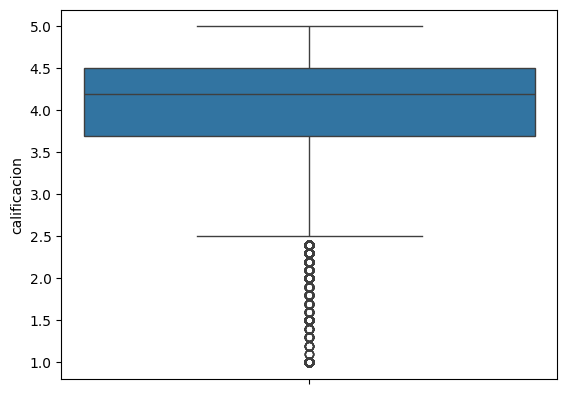

In [275]:
fig = sns.boxplot(df_restaurantes['calificacion'])
fig.plot()

In [276]:
df['calificacion'].describe()

count    111914.000000
mean          4.053937
std           0.665589
min           1.000000
25%           3.699219
50%           4.199219
75%           4.500000
max           5.000000
Name: calificacion, dtype: float64

Decidimos utilizar el promedio como umbral

In [277]:
umbral = df['calificacion'].mean()
df.loc[:, 'calificacion'] = df.loc[:, 'calificacion'].apply(lambda x: 1 if x >= umbral else 0)
df.loc[:, 'calificacion'] = df.loc[:, 'calificacion'].astype(int)

### 2.1.4 Selección de Features para el ML

In [280]:
dropear = ["nombre","index", "id_restaurante","categorias", "id_estado", "atributos", "cantidad_resenas"]
# dropear = ["index", "id_restaurante","categorias", "atributos", "nombre"]

df = df.loc[:, ~df.columns.isin(dropear)]



### 2.1.5 Over y Under Sampling

In [281]:
df['calificacion'].value_counts().sort_values()

calificacion
0.0    48943
1.0    62971
Name: count, dtype: int64

In [282]:
# df = pd.concat([df.query("calificacion == 1").sample(37550),df.query("calificacion == 0")])

In [283]:
df['calificacion'].value_counts()

calificacion
1.0    62971
0.0    48943
Name: count, dtype: int64

In [284]:
df[df.columns[:-53]] = df[df.columns[:-53]].astype(int)

Salvamos el dataframe ya preprocesado

In [285]:
df.to_parquet('df_preprocesado.parquet')

## 2.2 Modelos

In [288]:
scores = dict()

df = df.read_parquet('df_preprocesado.parquet')

X = df.drop(['calificacion'], axis=1)
y = df['calificacion'] 

### 2.2.1 Prueba de Regresores: Regresión Logística, RandomForest, HistGradientBoostin, XGBClassifier, Kneighbors, GradientBoosting

In [289]:
def elegir_configuracion():
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2)

    scalers = [StandardScaler(), MaxAbsScaler(), MinMaxScaler()]

    classifiers = [RandomForestClassifier(), LogisticRegression(), HistGradientBoostingClassifier(max_iter=100, learning_rate=0.1),
        XGBClassifier(use_label_encoder=False, eval_metric='logloss'), KNeighborsClassifier(), GradientBoostingClassifier()]

    for s in scalers:
        for c in classifiers:
            print(f"Scaler: {s.__class__.__name__}, Classifier: {c.__class__.__name__}")
            pipe = Pipeline([('scaler', s), ('clasiffier', c)], verbose=True)
            pipe.fit(X_train, y_train)  # apply scaling on training data
            # scores["HistGradientBoostingClassifier"] = pipe.score(X_test, y_test)
            # Print the accuracy score
            score = pipe.score(X_test, y_test)
            print(f"Accuracy: {score:.4f}")

            if score >= 0.745:
                cm = confusion_matrix(y_test, pipe.predict(X_test))
                disp = ConfusionMatrixDisplay(confusion_matrix=cm)
                disp.plot(cmap='Blues')
                # disp = ConfusionMatrixDisplay.from_estimator(c, X_test, y_test, cmap='viridis', display_labels=pipe.classes_)
                # disp.plot()
                plt.title(f"Confusion Matrix - {s.__class__.__name__} + {c.__class__.__name__}")
                plt.show()
    # print(classification_report(y_test, pipe.predict(X_test)))

Decidiendo Utilizar XGBoosting y StandardScaler procedemos a afinar parámetros

In [293]:
# Supongamos que X y y son tus datos y etiquetas

def afinar_parametros():
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Crear el pipeline
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('xgb', XGBClassifier(use_label_encoder=False, eval_metric='logloss'))
    ])


    param_grid = {
        'xgb__n_estimators': [150, 200, 250],
        'xgb__learning_rate': [0.05, 0.1, 0.15],
        'xgb__max_depth': [5, 7, 9],
        'xgb__subsample': [0.6, 0.7, 0.8],
        'xgb__colsample_bytree': [0.75, 0.8, 0.85]
    }

    # Crear el GridSearchCV
    grid_search = GridSearchCV(pipeline, param_grid, cv=5, n_jobs=-1, scoring='accuracy')

    # Ajustar el GridSearchCV a los datos de entrenamiento
    grid_search.fit(X_train, y_train)

    # Obtener el mejor modelo
    best_model = grid_search.best_estimator_

    # Imprimir los mejores hiperparámetros
    print(f"Best parameters: {grid_search.best_params_}")
    print(f"Best cross-validation score: {grid_search.best_score_}")

    # Evaluar el modelo en los datos de prueba
    y_pred = best_model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Test accuracy: {accuracy:.2f}")


KeyboardInterrupt: 

**Best parameters:**
```python
{'colsample_bytree': 0.85, 
'learning_rate': 0.05, 
'max_depth': 9, 
'n_estimators': 250, 
'xgb__subsample': 0.8}
```

**Best cross-validation score:** ```0.760407```

**Test accuracy:** ```0.76```

Test accuracy: 0.89
              precision    recall  f1-score   support

         0.0       0.87      0.89      0.88      9779
         1.0       0.91      0.90      0.90     12604

    accuracy                           0.89     22383
   macro avg       0.89      0.89      0.89     22383
weighted avg       0.89      0.89      0.89     22383



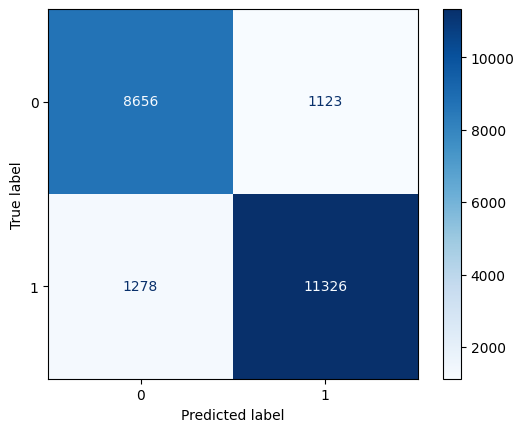

In [304]:

# Supongamos que X y y son tus datos y etiquetas
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


params = {'colsample_bytree': 0.85,
 'learning_rate': 0.1,
 'max_depth': 9,
 'n_estimators': 250,
 'subsample': 0.8,
 'eval_metric': 'logloss'}


# Crear el pipeline
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('xgb', XGBClassifier(**params))
])

pipeline.fit(X_test, y_test)


# Evaluar el modelo en los datos de prueba
y_pred = pipeline.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Test accuracy: {accuracy:.2f}")

print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)

disp.plot(cmap='Blues')
plt.show()



In [313]:
import pickle

filename = 'modelo_89.pickle'
pickle.dump(pipeline, open(filename, 'wb'))

modelo = pickle.load(open(filename, 'rb'))


# a = pd.DataFrame(np.array([['female',1,65.8,18,0,0,'C']]),columns = x_train.columns)

modelo.predict(X_proc)

array([0, 0, 0, ..., 1, 1, 1])

In [312]:
len(X_proc)

111914

In [ ]:
grid_search.best_params_

{'xgb__colsample_bytree': 0.85,
 'xgb__learning_rate': 0.05,
 'xgb__max_depth': 9,
 'xgb__n_estimators': 150,
 'xgb__subsample': 0.8}

In [ ]:
import joblib
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier

# joblib.dump(pipeline, 'model_pipeline_2.pkl')

In [ ]:
with open('model_params.json', 'w') as f:
    json.dump(params, f)

In [ ]:
# Cargar el pipeline desde el archivo
loaded_pipeline = joblib.load('model_pipeline_2.pkl')

# Cargar los hiperparámetros desde el archivo JSON
with open('model_params.json', 'r') as f:
    loaded_params = json.load(f)

print("Loaded parameters:", loaded_params)

# Evaluar el modelo cargado en los datos de prueba
y_pred = loaded_pipeline.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(y_pred)
print(f"Test accuracy: {accuracy:.2f}")


Loaded parameters: {'colsample_bytree': 0.75, 'learning_rate': 0.05, 'max_depth': 9, 'n_estimators': 250, 'subsample': 0.6}


g:\cursos_2023\HENRY\DATA07\PF\PF_DATAPT07\.venv10\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


ValueError: X has 122 features, but StandardScaler is expecting 121 features as input.

In [311]:
# X_subway = X.reset_index().merge(df_restaurantes.reset_index().query("id_restaurante == '0x865681564f2dfd47:0x1f030438f1ceed23'"), on='index').query("nombre == 'Subway'").drop(columns=['id_restaurante',	'id_estado',	'nombre',	'categorias',	'cantidad_resenas',	'latitud_y',	'longitud_y',	'atributos',	'calificacion',	'origen_y', 'level_0', 'index']).rename({'latitud_x':'latitud', "longitud_x":"longitud", "origen_x":"origen"}, axis=1)

cl = ['id_restaurante',
 'id_estado',
 'nombre',
 'categorias',
 'cantidad_resenas',
 'latitud_y',
 'longitud_y',
 'atributos',
 'calificacion',
 'origen_y',
 'level_0',
 'index']

X_subway = X.reset_index().merge(df_restaurantes.query("nombre == 'Subway'").reset_index(), on='index')
X_subway_proc = X_subway.drop(columns=cl).rename({'latitud_x':'latitud', "longitud_x":"longitud", "origen_x":"origen"}, axis=1)
X_ = X.reset_index().merge(df_restaurantes.reset_index(), on='index')
X_proc = X_.drop(columns=cl).rename({'latitud_x':'latitud', "longitud_x":"longitud", "origen_x":"origen"}, axis=1)

X_subway.to_parquet('X_subway.parquet')
X_subway_proc.to_parquet('X_subway_proc.parquet')
X_.to_parquet('X_.parquet')
X_proc.to_parquet('X_proc.parquet')

In [ ]:
from pprint import pprint

def get_atributos(id_restaurante):
    
    df = X_subway.query(f"id_restaurante == '{id_restaurante}'")
    tipo_atributo = [a.split("_")[0] for a in df.columns.tolist()[1:70]]
    atributo = [a.split("_")[1] for a in df.columns.tolist()[1:70]]
    atributos_dict = {'access': {}, 'amen': {}, 'atmos': {},  'crowd': {},  'dining': {},  'health': {},
     'high': {},  'offer': {},  'pay': {}, 'popular': {},  'service': {}}
   
    for ta, a in zip(tipo_atributo, atributo):
            atributos_dict[ta][a] = df.loc[:,f"{ta}_{a}"].values[0]

            
    return atributos_dict

# pprint(get_atributos("0x865681564f2dfd47:0x1f030438f1ceed23"))
# pprint(get_atributos("_AvFiC-whJC9g9ndd3XGtA"))


In [ ]:
# %pip install streamlit

In [ ]:
import pickle

filename = 'modelo_89.pickle'
pickle.dump(pipeline, open(filename, 'wb'))

modelo = pickle.load(open(filename, 'rb'))


# a = pd.DataFrame(np.array([['female',1,65.8,18,0,0,'C']]),columns = x_train.columns)

modelo.predict(X_subway_proc)

NameError: name 'X_subway_proc' is not defined

In [ ]:
modelo

Pipeline(steps=[('scaler', StandardScaler()),
                ('xgb',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.8, device=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric=None,
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=0.05,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=9, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=250, n_jobs=None,
                               num_parallel_tree=None, random_state=None, ...))])

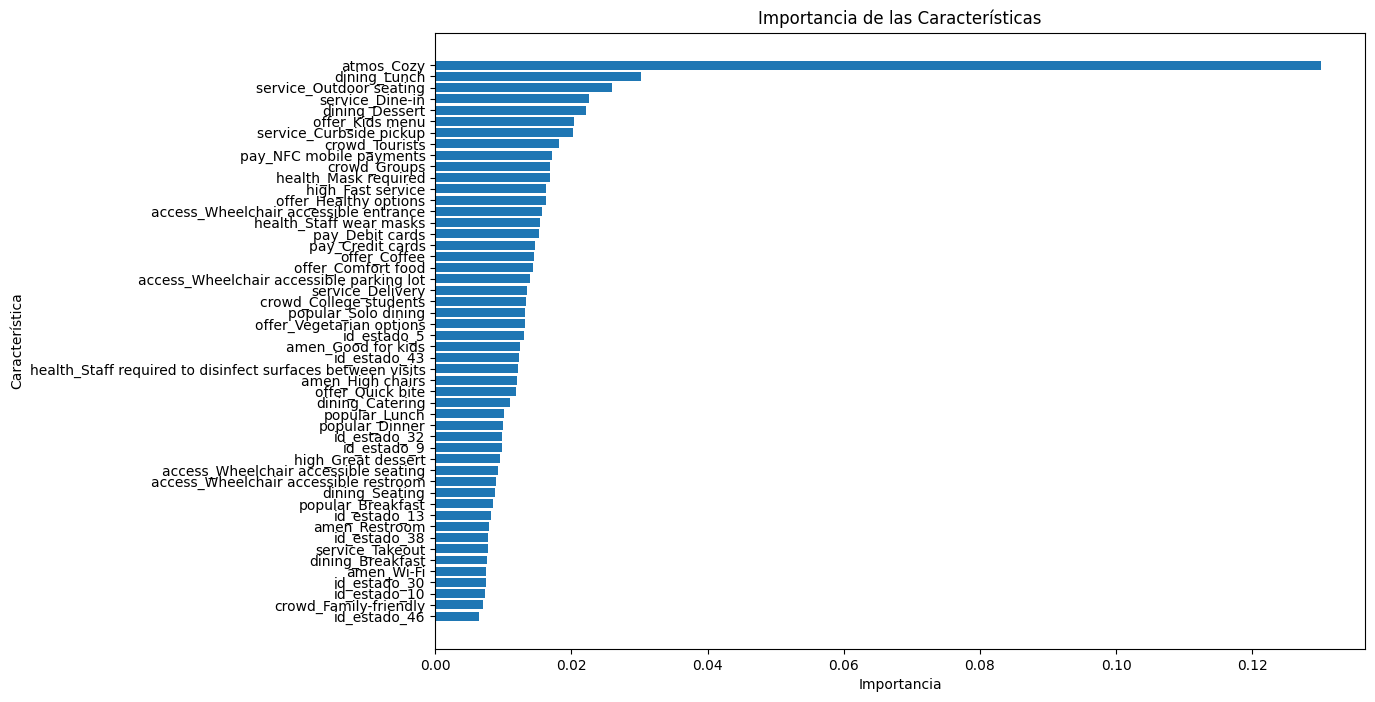

['atmos_Cozy', 'dining_Lunch', 'service_Outdoor seating', 'service_Dine-in', 'dining_Dessert', 'offer_Kids menu', 'service_Curbside pickup', 'crowd_Tourists', 'pay_NFC mobile payments', 'crowd_Groups', 'health_Mask required', 'high_Fast service', 'offer_Healthy options', 'access_Wheelchair accessible entrance', 'health_Staff wear masks', 'pay_Debit cards', 'pay_Credit cards', 'offer_Coffee', 'offer_Comfort food', 'access_Wheelchair accessible parking lot', 'service_Delivery', 'crowd_College students', 'popular_Solo dining', 'offer_Vegetarian options', 'id_estado_5', 'amen_Good for kids', 'id_estado_43', 'health_Staff required to disinfect surfaces between visits', 'amen_High chairs', 'offer_Quick bite', 'dining_Catering', 'popular_Lunch', 'popular_Dinner', 'id_estado_32', 'id_estado_9', 'high_Great dessert', 'access_Wheelchair accessible seating', 'access_Wheelchair accessible restroom', 'dining_Seating', 'popular_Breakfast', 'id_estado_13', 'amen_Restroom', 'id_estado_38', 'service_Ta

In [ ]:

model = DecisionTreeClassifier(random_state=42)
model.fit(X, y)

feature_importances = model.feature_importances_

features = pd.DataFrame({
    'Feature': X.columns,
    'Importance': feature_importances
})

# Ordenar las características por importancia
features = features.sort_values(by='Importance', ascending=False).head(50)

# Visualizar la importancia de las características
plt.figure(figsize=(12, 8))
plt.barh(features['Feature'], features['Importance'])
plt.xlabel('Importancia')
plt.ylabel('Característica')
plt.title('Importancia de las Características')
plt.gca().invert_yaxis()
plt.show()

print(features['Feature'].tolist())

Accuracy (XGBoost): 0.7460414751251405


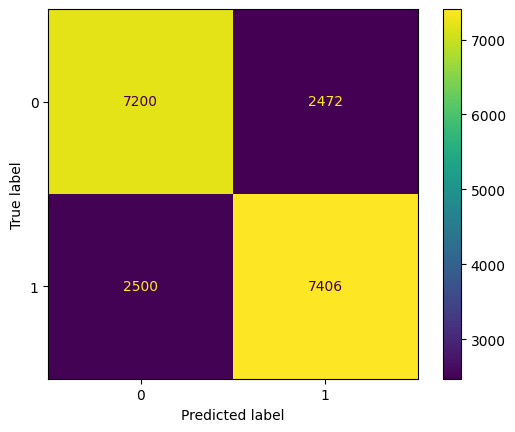

              precision    recall  f1-score   support

           0       0.74      0.74      0.74      9672
           1       0.75      0.75      0.75      9906

    accuracy                           0.75     19578
   macro avg       0.75      0.75      0.75     19578
weighted avg       0.75      0.75      0.75     19578



In [ ]:

# Dividir los datos en conjuntos de entrenamiento y prueba

from xgboost import DMatrix, train

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

dtrain = DMatrix(X_train_scaled, label=y_train)
dtest = DMatrix(X_test_scaled, label=y_test)

# Definir los parámetros del modelo
params = {
    'objective': 'multi:softmax',  # Para clasificación multiclase
    'num_class': 2,  # Número de clases en la variable de salida
    'eval_metric': 'merror',  # Métrica de evaluación
    'learning_rate': 0.1,
    'max_depth': 5
}

# Entrenar el modelo XGBoost
num_rounds = 300

xgb_model = train(params, dtrain, num_rounds)

# Hacer predicciones
y_pred_xgb = xgb_model.predict(dtest)

# Evaluar el modelo
accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
print(f'Accuracy (XGBoost): {accuracy_xgb}')
scores["Random Forest (XGBoost)"] = accuracy_score(y_test, y_pred_xgb)


# # Print classification report
# print(classification_report(y_test, y_pred_xgb))

cm = confusion_matrix(y_test, y_pred_xgb)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)

disp.plot()
plt.show()
print(classification_report(y_test, y_pred_xgb))


In [ ]:
# print(f"Columnas dropear {dropear}")
# print(f"random forest: {round(random_forest_accuracy*100, 3)}")
# print(f"linear reg   : {round(linear_reg_accuracy*100, 3)}" )
# print(f"xgboost      : {round(xgboost_accuracy*100, 3)}"  )

print(scores)

{'Logistic Regression': 0.7220088264138608, 'Random Forest Classifier': 0.7412553121935272, 'HistGradientBoostingClassifier': 0.7430532853873815, 'Random Forest 2': 0.7425220660346519, 'Logistic Regression 2': 0.7231586474614363, 'Random Forest (XGBoost)': 0.7460414751251405}


In [ ]:
# df_reviews = pd.read_parquet(r'Datawarehouse\reviewstexto.parquet')


- accesibilidad 10 columnas, 5 de yelp y 5 de google, (lift - elevator)
- beer - alcohol
- one hot encoding o level encoding a los estados
- crowd, family friend
- reseña, cloud, variables de peso
- balanceo de la variable target, min max scaler
- mapa mental de las categorías nuevas
- qué nuevos valores del ML agregar al Dashboard
- subir al datawarehouse las nuevas categorías


In [ ]:
# import optuna
# import xgboost as xgb
# from sklearn.preprocessing import StandardScaler
# from sklearn.model_selection import cross_val_score, StratifiedKFold
# from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay
# import matplotlib.pyplot as plt

# # Asumiendo que X y y ya están definidos

# # Escalar todo el dataset
# scaler = StandardScaler()
# X_scaled = scaler.fit_transform(X)

# def objective(trial):
#     params = {
#         'objective': 'multi:softmax',
#         'num_class': 2,
#         'eval_metric': 'merror',
#         'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
#         'max_depth': trial.suggest_int('max_depth', 3, 10),
#         'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
#         'gamma': trial.suggest_float('gamma', 0.01, 1.0),
#         'subsample': trial.suggest_float('subsample', 0.5, 1.0),
#         'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
#         'n_estimators': trial.suggest_int('n_estimators', 100, 500)
#     }

#     xgb_model = xgb.XGBClassifier(**params)

#     cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
#     scores = cross_val_score(xgb_model, X_scaled, y, cv=cv, scoring='accuracy')
#     return scores.mean()

# # Crear el estudio y optimizar los hiperparámetros
# study = optuna.create_study(direction='maximize')
# study.optimize(objective, n_trials=10)

# # Imprimir los mejores parámetros encontrados por Optuna
# print(f'Best trial: {study.best_trial.value}')
# print(f'Best parameters: {study.best_trial.params}')

# # Entrenar el modelo final con los mejores parámetros
# best_params = study.best_trial.params
# xgb_model = xgb.XGBClassifier(**best_params)
# xgb_model.fit(X_scaled, y)

# # Hacer predicciones en el mismo conjunto para obtener la matriz de confusión y el informe de clasificación
# y_pred_xgb = xgb_model.predict(X_scaled)

# # Matriz de confusión
# cm = confusion_matrix(y, y_pred_xgb)
# disp = ConfusionMatrixDisplay(confusion_matrix=cm)
# disp.plot()
# plt.show()

# # Informe de clasificación
# print(classification_report(y, y_pred_xgb))


In [ ]:
# %pip install ipywidgets widgetsnbextension pandas-profiling

In [ ]:
# %pip install optuna

In [ ]:
X

,access_Wheelchair accessible entrance,access_Wheelchair accessible parking lot,access_Wheelchair accessible restroom,access_Wheelchair accessible seating,access_Wheelchair-accessible entrance,amen_Bar onsite,amen_Good for kids,amen_High chairs,amen_Restroom,amen_Wi-Fi,...,id_estado_41,id_estado_42,id_estado_43,id_estado_44,id_estado_45,id_estado_46,id_estado_47,id_estado_48,id_estado_49,id_estado_50
19852,1,0,1,1,0,0,1,1,1,0,...,0,1,0,0,0,0,0.0,0.0,0.0,0.0
16455,1,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0.0,0.0,0.0,0.0
103747,0,0,0,0,0,0,1,1,0,0,...,0,0,0,0,0,0,0.0,0.0,0.0,0.0
92468,1,0,0,0,0,0,1,0,0,0,...,0,0,1,0,0,0,0.0,0.0,0.0,0.0
81947,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
111901,1,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0.0,0.0,0.0,0.0
111904,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0.0,0.0,0.0,0.0
111905,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0.0,0.0,0.0,0.0
111908,1,0,0,0,0,0,1,1,0,0,...,0,0,0,0,0,0,0.0,0.0,0.0,0.0


InvalidIndexError: (slice(None, None, None), 0)

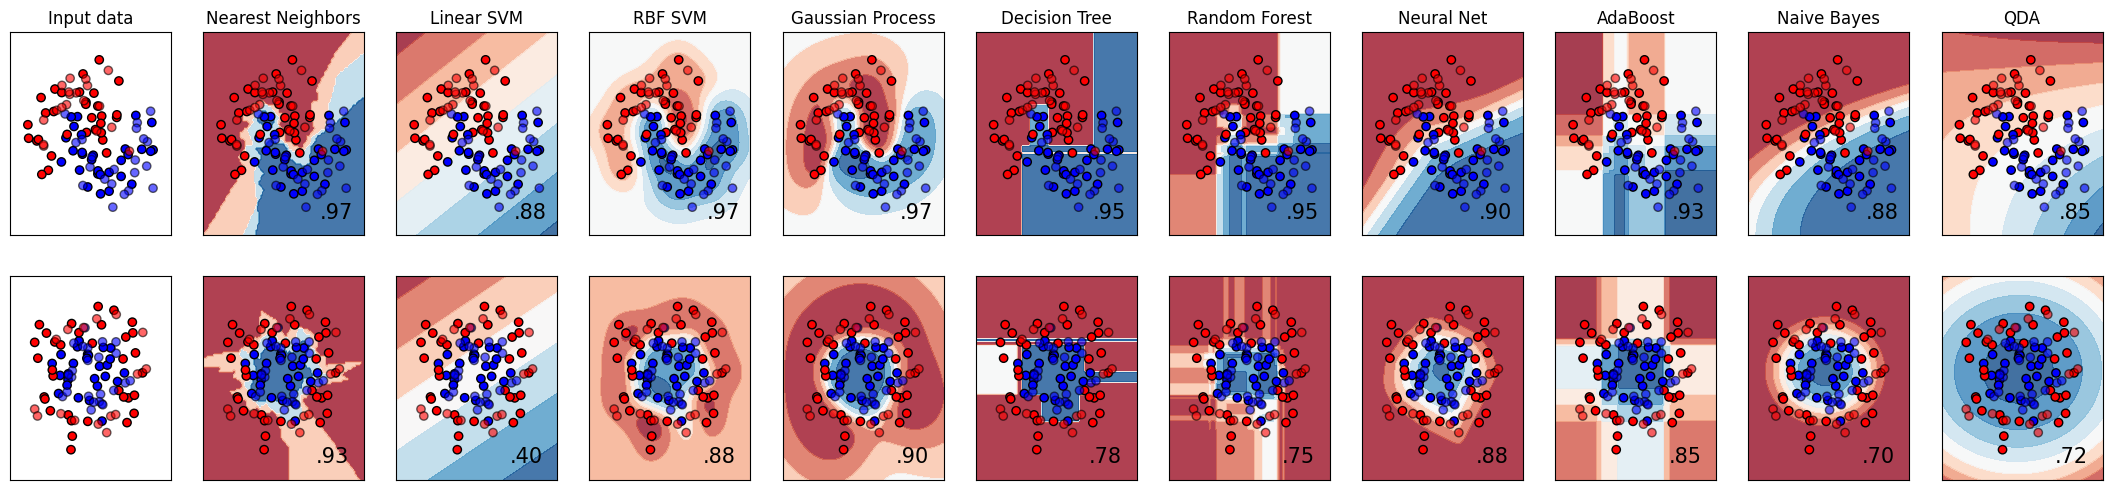

In [ ]:
# Code source: Gaël Varoquaux
#              Andreas Müller
# Modified for documentation by Jaques Grobler
# License: BSD 3 clause

import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import ListedColormap

from sklearn.datasets import make_circles, make_classification, make_moons
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

names = [
    "Nearest Neighbors",
    "Linear SVM",
    "RBF SVM",
    "Gaussian Process",
    "Decision Tree",
    "Random Forest",
    "Neural Net",
    "AdaBoost",
    "Naive Bayes",
    "QDA",
]

classifiers = [
    KNeighborsClassifier(3),
    SVC(kernel="linear", C=0.025, random_state=42),
    SVC(gamma=2, C=1, random_state=42),
    GaussianProcessClassifier(1.0 * RBF(1.0), random_state=42),
    DecisionTreeClassifier(max_depth=5, random_state=42),
    RandomForestClassifier(
        max_depth=5, n_estimators=10, max_features=1, random_state=42
    ),
    MLPClassifier(alpha=1, max_iter=1000, random_state=42),
    AdaBoostClassifier(algorithm="SAMME", random_state=42),
    GaussianNB(),
    QuadraticDiscriminantAnalysis(),
]

# X, y = make_classification(
#     n_features=2, n_redundant=0, n_informative=2, random_state=1, n_clusters_per_class=1
# )
rng = np.random.RandomState(2)
X += 2 * rng.uniform(size=X.shape)
linearly_separable = (X, y)

datasets = [
    make_moons(noise=0.3, random_state=0),
    make_circles(noise=0.2, factor=0.5, random_state=1),
    linearly_separable,
]

figure = plt.figure(figsize=(27, 9))
i = 1
# iterate over datasets
for ds_cnt, ds in enumerate(datasets):
    # preprocess dataset, split into training and test part
    X, y = ds
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.4, random_state=42
    )

    x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5

    # just plot the dataset first
    cm = plt.cm.RdBu
    cm_bright = ListedColormap(["#FF0000", "#0000FF"])
    ax = plt.subplot(len(datasets), len(classifiers) + 1, i)
    if ds_cnt == 0:
        ax.set_title("Input data")
    # Plot the training points
    ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright, edgecolors="k")
    # Plot the testing points
    ax.scatter(
        X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright, alpha=0.6, edgecolors="k"
    )
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    ax.set_xticks(())
    ax.set_yticks(())
    i += 1

    # iterate over classifiers
    for name, clf in zip(names, classifiers):
        ax = plt.subplot(len(datasets), len(classifiers) + 1, i)

        clf = make_pipeline(StandardScaler(), clf)
        clf.fit(X_train, y_train)
        score = clf.score(X_test, y_test)
        DecisionBoundaryDisplay.from_estimator(
            clf, X, cmap=cm, alpha=0.8, ax=ax, eps=0.5
        )

        # Plot the training points
        ax.scatter(
            X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright, edgecolors="k"
        )
        # Plot the testing points
        ax.scatter(
            X_test[:, 0],
            X_test[:, 1],
            c=y_test,
            cmap=cm_bright,
            edgecolors="k",
            alpha=0.6,
        )

        ax.set_xlim(x_min, x_max)
        ax.set_ylim(y_min, y_max)
        ax.set_xticks(())
        ax.set_yticks(())
        if ds_cnt == 0:
            ax.set_title(name)
        ax.text(
            x_max - 0.3,
            y_min + 0.3,
            ("%.2f" % score).lstrip("0"),
            size=15,
            horizontalalignment="right",
        )
        i += 1

plt.tight_layout()
plt.show()